In [81]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plot
import statsmodels.api as sm
import math

In [2]:
data = np.loadtxt("data.txt")
data = np.concatenate(data)

# 1. sample characteristics

In [16]:
mean = np.mean(data)
var = np.var(data)
kurtosis = stat.kurtosis(data)
skewness = stat.skew(data)
n = np.size(data)

print(f"mean: {mean}")
print(f"variation: {var}")
print(f"kurtosis: {kurtosis}")
print(f"skewness: {skewness}")
print(f"size: {n}")




mean: -1.100377148133333
variation: 1.8506794964312567
kurtosis: -0.6238925605364338
skewness: -0.21527923156203657
size: 60


# 2. histogramm and sample cdf

(array([ 4.,  2., 10.,  6.,  6., 10., 10.,  8.,  3.,  1.]),
 array([-3.969549  , -3.38107839, -2.79260778, -2.20413717, -1.61566656,
        -1.02719595, -0.43872534,  0.14974527,  0.73821588,  1.32668649,
         1.9151571 ]),
 <BarContainer object of 10 artists>)

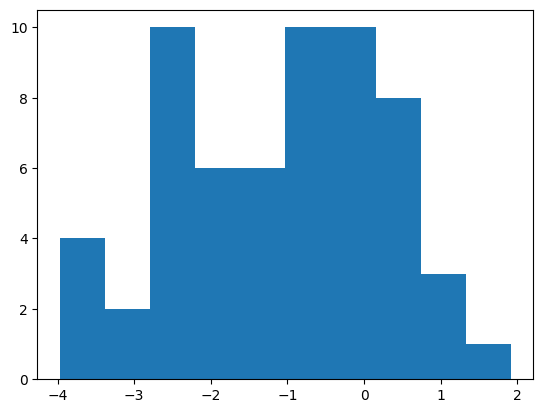

In [5]:
plot.hist(data)

Text(0.5, 1.0, 'empirical cdf')

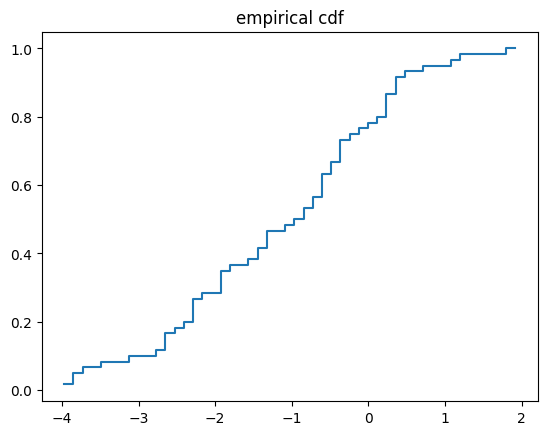

In [11]:
ecdf = sm.distributions.ECDF(data)
x = np.linspace(min(data), max(data))
y = ecdf(x)
plot.step(x, y)
plot.title("empirical cdf")

# 3. gamma confidence interval for edf

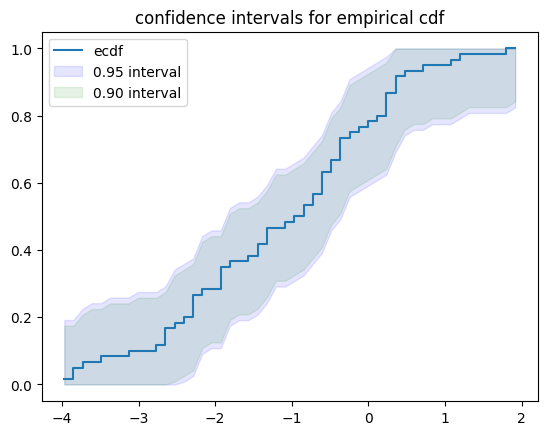

In [46]:
lower_bound = lambda x, perc: ecdf(x) - stat.kstwobign.ppf(perc) / n**0.5
upper_bound = lambda x, perc: ecdf(x) + stat.kstwobign.ppf(perc) / n**0.5


x = np.linspace(min(data), max(data))
y = ecdf(x)
lb_95 = np.maximum(lower_bound(x, 0.95), np.zeros(np.size(x)))
ub_95 = np.minimum(upper_bound(x, 0.95), np.ones(np.size(x)))
lb_90 = np.maximum(lower_bound(x, 0.90), np.zeros(np.size(x)))
ub_90 = np.minimum(upper_bound(x, 0.90), np.ones(np.size(x)))


fig, ax = plot.subplots()
ax.step(x,y)
ax.fill_between(x, lb_95, ub_95, color='b', alpha=.1)
ax.fill_between(x, lb_90, ub_90, color='g', alpha=.1)
plot.title("confidence intervals for empirical cdf")
plot.legend(["ecdf", "0.95 interval", "0.90 interval"])

# 4-5 Chi square test
looks like gamma distribution(cuz of skew)

$X_n = \sum (O_i - E_i)^2 / E_i$, 

$O_i$ - number of observed instances in i-th interval, $E_i$ - expected instances in i-th interval 

[ 6. 16. 16. 18.  4.]
[ 5 14 19 14  5]
chi_sq_stat_value: 2.302255639097744
quantile_chi2: 5.991464547107979
p_value: 0.31627986154230503


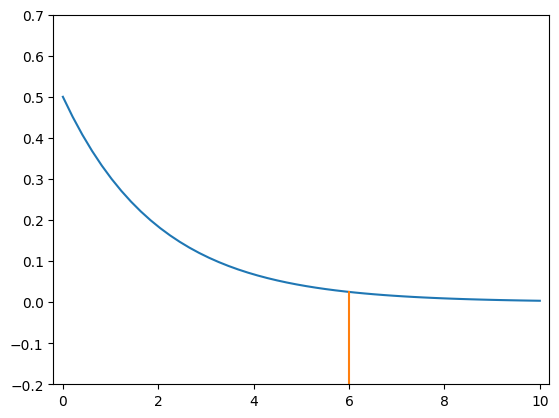

In [120]:
# split data into intervals of same length s.t. each of its length is approximately 1
# (cuz O_i must be more than 5 and such length allows it, looking at histogramm)
def calc_obs(sample, grid):
    obs = np.zeros(np.size(grid) - 1)
    for val in sample:
        for i in range(np.size(grid) - 1):
            obs[i] = obs[i] + 1 if grid[i] <= val <= grid[i+1] else obs[i]
    return obs

def calc_exp_gamma(grid, param, n=n):
    N = np.size(grid) - 1
    exp = np.zeros(N)
    for i in range(N):
        lb = grid[i]
        ub = grid[i+1]
        loc = param[0]
        a = param[1]
        beta = param[2]
        exp[i] = (stat.gamma.cdf(ub, a, loc=loc, scale=1/beta) - stat.gamma.cdf(lb, loc=param[0], scale=param[1])) * n
    return exp


def calc_exp_norm(grid, param, n=n):
    N = np.size(grid) - 1
    exp = np.zeros(N)
    for i in range(N):
        lb = grid[i]
        ub = grid[i+1]
        exp[i] = (stat.norm.cdf(ub, loc=param[0], scale=param[1]) - stat.norm.cdf(lb, loc=param[0], scale=param[1])) * n
    return exp

def calc_grid(x, interval_length=1):
    max = np.max(x)
    min = np.min(x)
    return np.linspace(min, max, num=int((max - min) // interval_length + 1))
    
def calc_chi_square_stat(obs, exp):
    return np.sum((obs - exp)**2 / exp)  

def chi_square_stat(param):
    grid = calc_grid(data)
    obs = calc_obs(data, grid)
    exp = calc_exp_norm(grid, param)
    return calc_chi_square_stat(obs,exp)  

from scipy.optimize import minimize
opt_param_norm = minimize(chi_square_stat, [mean,var**0.5]).x
grid = calc_grid(data)
exp = calc_exp_norm(grid, opt_param_norm)
exp = np.vectorize(round)(exp)
obs = calc_obs(data, grid)

print(obs)
print(exp)

chi_sq_stat_value = calc_chi_square_stat(obs, exp)
df = np.size(obs) - np.size(opt_param_norm) - 1
quantile_chi2 = stat.chi2.ppf(0.95, df=df)
p_value = 1 - stat.chi2.cdf(chi_sq_stat_value, df) 
print(f"chi_sq_stat_value: {chi_sq_stat_value}")
print(f"quantile_chi2: {quantile_chi2}")
print(f"p_value: {p_value}")

xx = np.linspace(0, 10, 50)
plot.xlim(-0.2, 10.2), plot.ylim(-0.2, 0.7)
plot.plot(xx, stat.chi2.pdf(xx, df=df), [quantile_chi2,quantile_chi2], [-0.9, stat.chi2.pdf(quantile_chi2,df=df)])

p-value is more than 5 percent significance level ($\alpha = 5$) => accept zero hypothesis

# 6. calculate maximum likelihood parameter estimation
for normal distribution, sample variance and expectation are ML estimations for variance and expectation accordingly

In [127]:
ml_exp = mean
ml_var = var

# 7. comparisson of sample and theoretical cdf and pdf

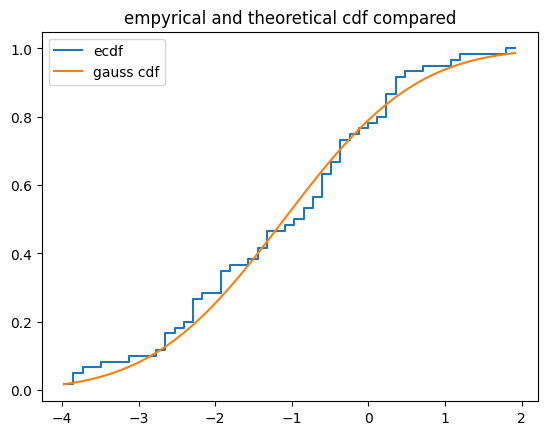

In [139]:
fig, ax = plot.subplots()
ax.step(x,y)
ax.plot(x, stat.norm.cdf(x, loc=ml_exp, scale=ml_var**0.5))
plot.title("empyrical and theoretical cdf compared")
plot.legend(["ecdf", "gauss cdf"])

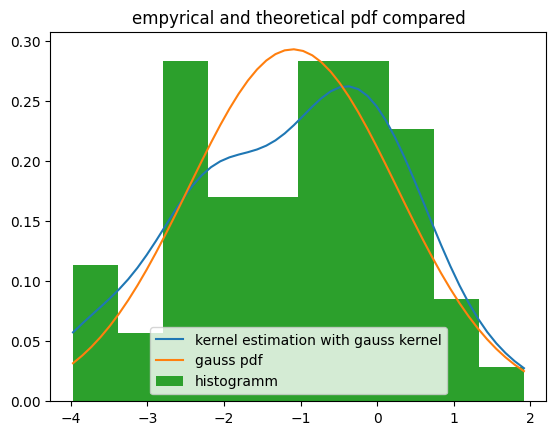

In [138]:
fig, ax = plot.subplots()
ax.plot(x, stat.gaussian_kde(data)(x),)
ax.plot(x, stat.norm.pdf(x, loc=ml_exp, scale=ml_var**0.5))
ax.hist(data, density=True, )
plot.title("empyrical and theoretical pdf compared")
plot.legend(["kernel estimation with gauss kernel","gauss pdf", "histogramm"])